<a href="https://colab.research.google.com/github/yzihan/Generative-AI/blob/main/generative%20method%20for%20creative%20applications-MAS.s66/Painting_with_StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Painting with StyleGAN 🎨
### Hello 👋 welcome to the painting with stylegan notebook. This notebook is intended to 
1. Help explore stylegan's latent space using variational autoencoders as a sort of filter and
2. Produce animations interpolating through stylegan's latent space using VAE "palettes" as a way to more graphically interface with the complicated space

The code below will train a VAE to represent portions of SG's 512-D latent space in 2-D. This representation will be plotted on a regular x/y axis for you to explore, and provides the optional injection of 'color' to your palette to explore less likely sections of the space. Once happy with a palette, get to painting! Draw a line through the space to interp from one image to another, draw a curve to pass through a third section, or draw a circle to create an interp that starts in one location and circles away and around back to the beginning to create loops. Hope you have fun painting!
-[@jmoso13](https://www.twitter.com/jmoso13)

Tutorial Video: https://youtu.be/pkYHMPoZrkg

# Download Things

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d406c2da-79e9-44c8-bbdc-0b0085a27245)


In [2]:
#@title Choose StyleGAN and Tensor Package Versions
import re
import os

supported_versions = 'stylegan3 | pytorch'#@param ['stylegan2 | tensorflow', 'stylegan3 | pytorch']
stylegan_version = int(re.findall('[0-9]+', supported_versions)[0]) 
tensor_pkg_version = supported_versions.split(' | ')[-1]

print(f'using\nstylegan version: {stylegan_version}\ntensor package version: {tensor_pkg_version}')

using
stylegan version: 3
tensor package version: pytorch


In [3]:
#@title Ensure Version Compatibility
if os.getcwd() == '/content':
  if tensor_pkg_version == 'tensorflow':
    %tensorflow_version 1.x
    !pip install h5py==2.10.0
  elif tensor_pkg_version == 'pytorch':
    !pip install Ninja opensimplex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 120 kB 29.0 MB/s 


In [4]:
#@title Clone Repos
%%capture
if os.getcwd() == '/content':
  !git clone https://github.com/jmoso13/mod-drawing-tool.git
  !git clone https://github.com/jmoso13/StyleGAN2-Latent-Tool.git
  if stylegan_version == 2:
    !git clone https://github.com/pbaylies/stylegan2-ada.git
    %cd /content/stylegan2-ada/
  elif stylegan_version == 3:
    !git clone https://github.com/dvschultz/stylegan3
    %cd stylegan3


  !pip install -e /content/StyleGAN2-Latent-Tool/
  %mv /content/StyleGAN2-Latent-Tool/latent_utils .
  %mv /content/StyleGAN2-Latent-Tool/js_latent_utils.egg-info .
  %mv /content/mod-drawing-tool/mods .

# Import Things

In [5]:
if tensor_pkg_version == 'tensorflow':
  import tensorflow as tf
  print(tf.__version__)
  from latent_utils.latent_utils import get_vae_dict, build_decoder, make_decoder_input, decode_pic, get_model_callbacks
  from latent_utils.gan_utils import convertZtoW
elif tensor_pkg_version == 'pytorch':
  import torch
  import torch.nn as nn
  import torch.nn.functional as F
  import torch.optim as optim
  from torch.utils.data import DataLoader, TensorDataset
  import legacy
  from latent_utils.latent_utils_torch import VAE
import dnnlib
import requests
import pickle as pkl
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mods.paths import CirclePath, LinePath
from mods.modulated_path import ModulatedPath
from mods import receivers, translators, voices

# Load Model
Here is where you can specify location of a stylegan2 pretrained pkl from file or from url

In [6]:
#@title Point to location of network-snapshot pkl
use_drive = True #@param{type: 'boolean'}
#@markdown leave this ^^ checked to connect to google drive
if use_drive:
  from google.colab import drive
  drive.mount('/content/drive')
  root_path = '/content/drive/MyDrive/AI/StyleGan_Drawing'
else:
  root_path = os.getcwd()

def createPath(filepath):
    os.makedirs(filepath, exist_ok=True)

model_path = f'{root_path}/models'
createPath(model_path)
palette_path = f'{model_path}/vae_palettes'
createPath(palette_path)
network_pkl_path = f'{model_path}/network_pkls'
createPath(network_pkl_path)
sketches_path = f'{root_path}/sketches_out'
createPath(sketches_path)
reel_path = f'{root_path}/reel'
createPath(reel_path)

network_pkl = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-metfaces-1024x1024.pkl"#@param{type: 'string'}

if stylegan_version == 2:
  # Start TF session and load network_pkl
  dnnlib.tflib.init_tf()
  with dnnlib.util.open_url(network_pkl) as fp:
    _G, _D, Gs = pkl.load(fp)
  # Some setup
  noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
  Gs_kwargs = dnnlib.EasyDict()
  Gs_kwargs.randomize_noise = False
  Gs_kwargs.output_transform = dict(func=dnnlib.tflib.convert_images_to_uint8, nchw_to_nhwc=True)
elif stylegan_version == 3:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f'torch_device: {device}')
  with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)


Mounted at /content/drive
torch_device: cuda


# Create VAE Palette

In [7]:
#@title Build Train/Test Data for our VAE, 
#@markdown sampled from normal Z space (mean==0, std==1)
#@markdown then converted to GAN disentangled W space
truncation_psi = 0.7#@param{type:'number'}
truncation_cutoff = False#@param{type:'boolean'}
if truncation_cutoff:
  truncation_cutoff_val = 100#@param{type:'number'}
else:
  truncation_cutoff_val = None
print(truncation_cutoff_val)
#@markdown these parameters have to do with bounding the GAN space, leave at defaults or try lowering/raising the parameters slightly. lower values should provide more coherency and less variety, while higher values should increase variety at the cost of coherency.

# Build val data set from 15000 random samples of Z space 
val_data_z = np.random.randn(15000, 512)
val_data = list()
i = 0

# Convert to W space
if tensor_pkg_version == 'tensorflow':
  print('building val set...')
  for vi in val_data_z:
    if i % 5000 == 0:
      print(i, ' datapoints built')
    latent = vi.reshape(1,-1)
    val_data.append(convertZtoW(Gs, latent)[:, 0][0])
    i += 1
  val_data = np.array(val_data)
elif tensor_pkg_version == 'pytorch':
  zs = torch.from_numpy(val_data_z).to(device)
  ws = G.mapping(z=zs, c=None, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff_val)
  _ = G.synthesis(ws[:1]) # warm up
  val_data = ws[:, 0, :].detach().cpu().numpy()

# Build train dataset from 100000 random samples of Z space
train_data_z = np.random.randn(100000, 512)
train_data = list()
i = 0

# Convert to W space
if tensor_pkg_version == 'tensorflow':
  print('building train set...')
  for ti in train_data_z:
    if i % 5000 == 0:
      print(i, ' datapoints built')
    latent = ti.reshape(1,-1)
    train_data.append(convertZtoW(Gs, latent)[:, 0][0])
    i += 1
  train_data = np.array(train_data)
elif tensor_pkg_version == 'pytorch':
  zs = torch.from_numpy(train_data_z).to(device)
  ws = G.mapping(z=zs, c=None, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff_val)
  _ = G.synthesis(ws[:1]) # warm up
  train_data = ws[:, 0, :].detach().cpu().numpy()

# Inspect
print(f"Train Size: {train_data.shape}\nVal Size: {val_data.shape}")


None
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
Train Size: (100000, 512)
Val Size: (15000, 512)


In [8]:
#@title Setup for VAE
model_name = 'styleGAN_VAE' #@param{type: 'string'}
nn_vae = False#@param{type:'boolean'}
#@markdown nn_vae is a variant on a vae only usable with tensorflow

if tensor_pkg_version == 'tensorflow':
  hidden_layers = 8
  lowest_dim = 2

  vae_dict = get_vae_dict(512, hidden_layers, lowest_dim, model_name, batch_norm=True, nn_vae=nn_vae)
  vae = vae_dict['vae']
  encoder = vae_dict['encoder']

elif tensor_pkg_version == 'pytorch':
  vae = VAE().to(device)
  optimizer = optim.Adam(vae.parameters(), lr=1e-4)
  train_tensor = torch.Tensor(train_data).to(device)
  train_dataset = TensorDataset(train_tensor)
  val_tensor = torch.Tensor(val_data).to(device)
  print(vae)


VAE(
  (fc1): Linear(in_features=512, out_features=506, bias=True)
  (fc2): Linear(in_features=506, out_features=487, bias=True)
  (fc3): Linear(in_features=487, out_features=455, bias=True)
  (fc4): Linear(in_features=455, out_features=411, bias=True)
  (fc5): Linear(in_features=411, out_features=355, bias=True)
  (fc6): Linear(in_features=355, out_features=285, bias=True)
  (fc7): Linear(in_features=285, out_features=203, bias=True)
  (fc8): Linear(in_features=203, out_features=109, bias=True)
  (fc_mu): Linear(in_features=109, out_features=2, bias=True)
  (fc_var): Linear(in_features=109, out_features=2, bias=True)
  (fcr8): Linear(in_features=2, out_features=109, bias=True)
  (fcr7): Linear(in_features=109, out_features=203, bias=True)
  (fcr6): Linear(in_features=203, out_features=285, bias=True)
  (fcr5): Linear(in_features=285, out_features=355, bias=True)
  (fcr4): Linear(in_features=355, out_features=411, bias=True)
  (fcr3): Linear(in_features=411, out_features=455, bias=True

In [9]:
#@title Train VAE Palette
mode = 'train'#@param['train', 'load']
load_palette_path = ''#@param{type:'string'}
#@markdown **load_palette_path** - if mode == load, load palette from this path instead of training. this parameter is ignored if mode == train

#@markdown Hyperparameters (shouldn't need to tweak unless interested)
batch_size = 256#@param{type: 'number'}
epochs = 3000#@param{type: 'number'}
kld_weight = 0.6#@param{type: 'number'}
recons_weight = 0.4#@param{type: 'number'}
patience = 15#@param{type: 'number'}
#@markdown **batch size** - how many training examples per batch, more means faster epochs but slower convergence, should be a power of 2

#@markdown **epochs** - how many times the training will loop through the entire dataset, interacts with patience which stops training early when the algorithm stops learning

#@markdown **kld_weight** - controls how much the latent space will be normally distributed (should be a value between 0-1, a weight of 0 is equivalent to a vanilla autoencoder)

#@markdown **patience** - controls how many epochs VAE will continue to train for without improvement before ending training 

if mode == 'train':
  if tensor_pkg_version == 'tensorflow':
    # Train
    es,mc = get_model_callbacks(model_name, patience=patience, model_dir_path=palette_path) # Patience determines how many epochs model will allow training to continue without improvement in val dataset
    vae.fit(train_data,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_data=(val_data ,None),
            callbacks=[es, mc])

  elif tensor_pkg_version == 'pytorch':
    dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    p_count = 0
    smallest_v_loss = 1000000000

    for epoch in range(epochs):    
      running_loss = 0.0
      vae.train()
      for i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data[0]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, mu, log_var = vae(inputs)
        recons_loss = F.mse_loss(outputs, inputs)*512
        kld_loss = -0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = -1)
        loss = torch.mean(recons_weight*recons_loss + kld_weight*kld_loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 40 == 39:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 40:.3f}, kld_loss: {torch.mean(kld_loss)}, recons_loss: {recons_loss/512}')
            running_loss = 0.0
      vae.eval()
      p_count += 1
      with torch.no_grad():
        v_outputs, v_mu, v_log_var = vae(val_tensor)
        v_recons_loss = F.mse_loss(v_outputs, val_tensor)*512
        v_kld_loss = -0.5 * torch.sum(1 + v_log_var - v_mu ** 2 - v_log_var.exp(), dim = -1)
        v_loss = torch.mean(recons_weight*v_recons_loss + kld_weight*v_kld_loss)
        if v_loss < smallest_v_loss:
          smallest_v_loss = v_loss
          p_count = 0
          torch.save(vae.state_dict(), f'{palette_path}/best_{model_name}.pt')
        print(f'\n\n EPOCH: {epoch + 1}  |  VAL LOSS: {v_loss}  |  PATIENCE COUNT: {p_count}\n')
      if p_count > patience:
        print(f'Patience reached at {epoch} epochs')
        break

  if tensor_pkg_version == 'tensorflow':
    vae.load_weights(f'{palette_path}/best_{model_name}.h5')
  elif tensor_pkg_version == 'pytorch':
    vae.load_state_dict(torch.load(f'{palette_path}/best_{model_name}.pt'))
    vae.eval() 
elif mode == 'load':
  if tensor_pkg_version == 'tensorflow':
    vae.load_weights(load_palette_path)
  elif tensor_pkg_version == 'pytorch':
    vae.load_state_dict(torch.load(load_palette_path))
    vae.eval() 
else:
  print('mode must be either train or load')

inject_image = False

[1,    40] loss: 76.129, kld_loss: 0.2903570532798767, recons_loss: 0.2964455783367157
[1,    80] loss: 58.422, kld_loss: 0.2554685175418854, recons_loss: 0.27546292543411255
[1,   120] loss: 56.821, kld_loss: 0.2197161465883255, recons_loss: 0.27393144369125366
[1,   160] loss: 56.252, kld_loss: 0.21578630805015564, recons_loss: 0.2735563814640045
[1,   200] loss: 56.016, kld_loss: 0.17220744490623474, recons_loss: 0.2734901010990143
[1,   240] loss: 55.822, kld_loss: 0.15580639243125916, recons_loss: 0.27110785245895386
[1,   280] loss: 55.795, kld_loss: 0.13266590237617493, recons_loss: 0.27072009444236755
[1,   320] loss: 55.707, kld_loss: 0.12994398176670074, recons_loss: 0.27399173378944397
[1,   360] loss: 55.692, kld_loss: 0.1313321590423584, recons_loss: 0.2721732258796692


 EPOCH: 1  |  VAL LOSS: 55.557559967041016  |  PATIENCE COUNT: 0

[2,    40] loss: 55.597, kld_loss: 0.11260807514190674, recons_loss: 0.2711668610572815
[2,    80] loss: 55.601, kld_loss: 0.11589705199003

# Inject Image - (Optional)

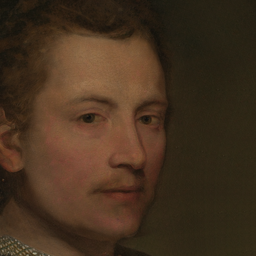

In [16]:
#@title Inject Image - (Optional)
noise = 0.0
inject_image = True#@param{type:'boolean'}
#@markdown **inject_image** - color your latent space palette with a randomly sampled image. re-run this cell until you get an image you like then run the next cell to display the latent space palette.
image_weight = 0.6#@param{type:'number'}
#@markdown **image_weight** - how far you want to skew your palette towards the injected image. a value of 0 makes no change, a value of 1 should guarantee the injected image shows up in the palette. values >1 will skew your palette past the image into brand new exciting territories.

if inject_image:
  if tensor_pkg_version == 'tensorflow':
    num_w = Gs.components.synthesis.input_shape[1]
    rint = np.random.randint(100000)
    noise = train_data[[rint]]
    noise = np.repeat(noise, num_w, axis=0).reshape(1, num_w, -1)
    img = Gs.components.synthesis.run(noise, **Gs_kwargs)[0]
  elif tensor_pkg_version == 'pytorch':
    num_w = G.synthesis.num_ws
    rint = np.random.randint(100000)
    noise = train_data[[rint]]
    noise = np.repeat(noise, num_w, axis=0).reshape(1, num_w, -1)
    img = G.synthesis(ws = torch.tensor(noise).to(device), noise_mode='const')[0]
    img = (img.permute(1, 2, 0) * 127.5 + 128).clamp(0, 255).detach().cpu().numpy()

  im = Image.fromarray(img.astype('uint8')).resize((256, 256), Image.LANCZOS)
  display(im)

# Display Palette

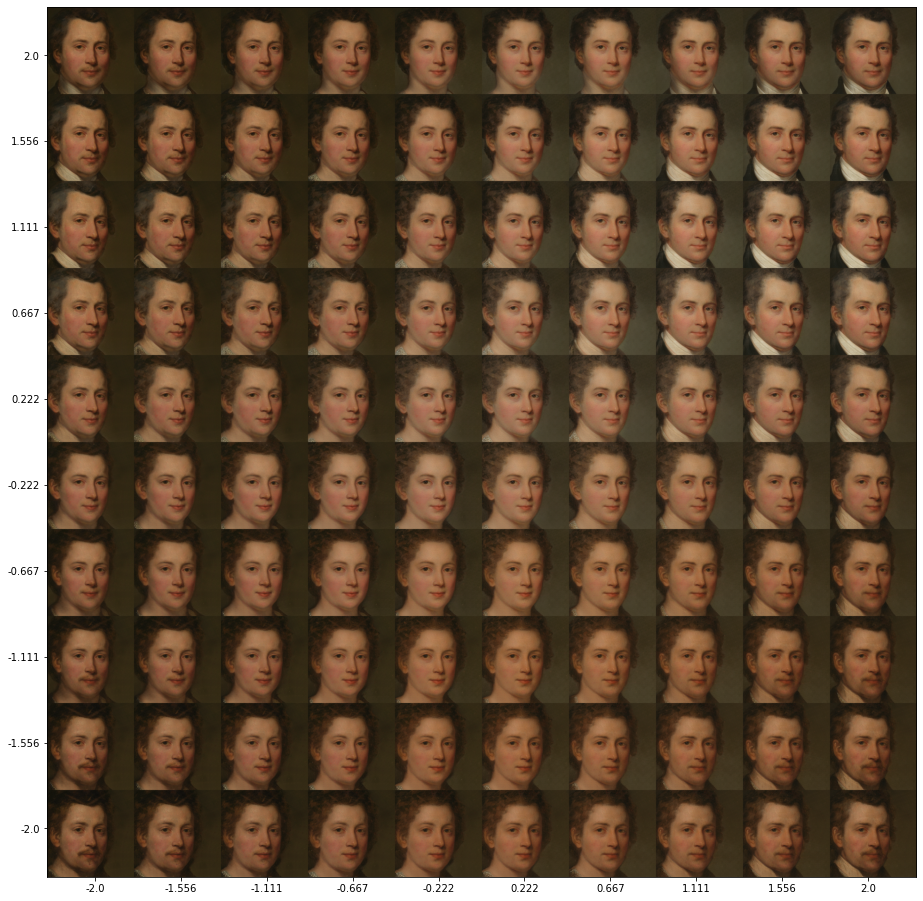

In [17]:
#@title Display Latent Space Palette
dim =  2#@param{type: 'number'}
#@markdown **dim** - controls how zoomed out you are on the VAE latent space. zoom in and out, see what you find! (higher -> out, lower -> in)
num =  10#@param{type: 'number'}
#@markdown **num** - controls how many images are displayed per side of your grid. more will show finer differences between each picture. too many can cause the notebook to run out of RAM and crash.

if tensor_pkg_version == 'tensorflow':
  decoder_input = make_decoder_input(2)
  decoder = build_decoder(vae, decoder_input)
  pic_size = Gs.output_shape[-1]
  num_w = Gs.components.synthesis.input_shape[1]
  points = np.linspace(-dim, dim, num)
  full_pic = np.zeros((pic_size*len(points), pic_size*len(points), 3))
  for i, y in enumerate(points):
    for j, x in enumerate(points):
      # print(x, y)
      if inject_image:
        img = decode_pic(decoder, x, y, num_w, Gs, Gs_kwargs, noise=noise, noise_weight=image_weight)
      else:
        img = decode_pic(decoder, x, y, num_w, Gs, Gs_kwargs)
      full_pic[pic_size*len(points)-(i*pic_size+pic_size):pic_size*len(points)-i*pic_size, j*pic_size:j*pic_size+pic_size] = img
elif tensor_pkg_version == 'pytorch':
  vae.eval()
  pic_size = G.synthesis(ws[:1]).shape[-1]
  num_w = G.synthesis.num_ws
  points = np.linspace(-dim, dim, num)
  full_pic = np.zeros((pic_size*len(points), pic_size*len(points), 3))
  for i, y in enumerate(points):
    for j, x in enumerate(points):
      # print(x, y)
      zij = vae.decode(torch.tensor(np.array([[x,y]]).astype('float32')).to(device))
      zij = np.repeat(zij.detach().cpu().numpy(), num_w, axis=0).reshape(1, num_w, -1)
      if inject_image:
        zij += image_weight*noise
      img = G.synthesis(ws = torch.tensor(zij).to(device), noise_mode='const')[0]
      img = (img.permute(1, 2, 0) * 127.5 + 128).clamp(0, 255).detach().cpu().numpy()
      full_pic[pic_size*len(points)-(i*pic_size+pic_size):pic_size*len(points)-i*pic_size, j*pic_size:j*pic_size+pic_size] = img
      
im = Image.fromarray(full_pic.astype('uint8')).resize((2048, 2048), Image.LANCZOS)

display_size = 'medium'#@param['small', 'medium', 'large', 'xlarge']
fgs_dict = dict(small=10, medium=16, large=26, xlarge=40)
fgs = fgs_dict[display_size]
fig, ax = plt.subplots(figsize=(fgs,fgs))
ax.imshow(im, extent=[-dim,dim,-dim,dim])
label_list = [round(p, 3) for p in points]
mn = points.min()
mx = points.max()
sz = mx-mn
diff = sz/(len(points)-1)
ax_points = np.linspace(mn+diff/2, (mx-diff)+diff/2, num)
ax.set_xticks(ax_points)
ax.set_xticklabels(label_list)
ax.set_yticks(ax_points)
ax.set_yticklabels(label_list)
plt.show()

In [18]:
#@title Save Palette
save_palette = True#@param{type:'boolean'}
save_name = 'palette_1'#@param{type:'string'}

if save_palette:
  if tensor_pkg_version == 'tensorflow':
    vae.save_weights(f'{palette_path}/{model_name}_{save_name}.h5')
  elif tensor_pkg_version == 'pytorch':
    torch.save(vae.state_dict(), f'{palette_path}/{model_name}_{save_name}.pt')


# Paint with VAE Palette



Start Pic:




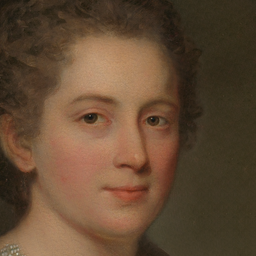



End Pic:




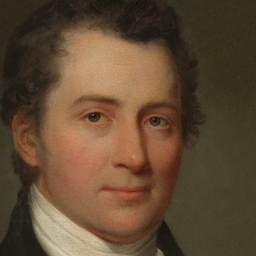



Path Preview:




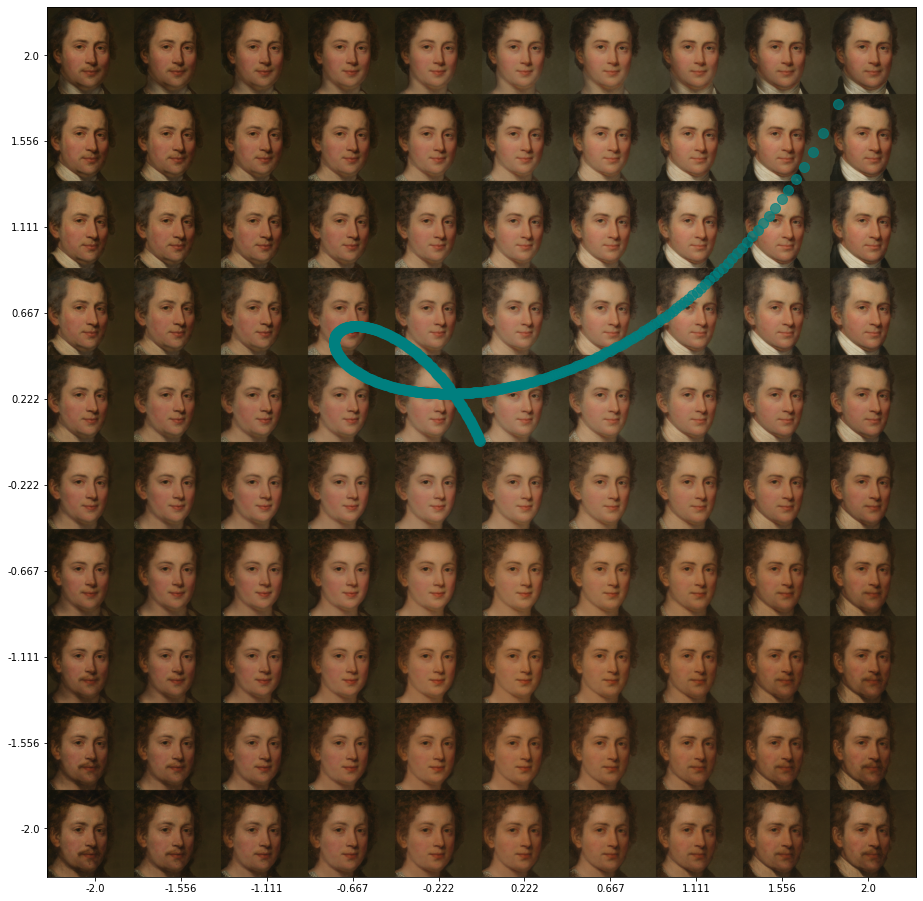

In [25]:
#@title Start and End Points
#@markdown Pick a start point and end point to draw through the 2D palette. Can choose line, curve, or circle path. Line path will connect the points in a straight line, curve can be a bit unexpected but will add a curving path, circle path will create a video that loops back to where it started. For circles, the start_point_x and start_point_y coordinates are the center of the circle and end_points are ignored. Path will be plotted so you can inspect what video you are getting. Videos are saved in a folder called sketches_out.
start_point_x = 0#@param{type:'number'}
start_point_y = 0#@param{type:'number'}

#@markdown ---------------------

end_point_x = 1.7#@param{type:'number'}
end_point_y = 1.7#@param{type:'number'}

#@markdown ---------------------

fps = 59.94#@param{type:'number'}
seconds = 8#@param{type:'number'}
path = 'curve'#@param['line', 'curve', 'circle']
curve_intensity = 2.0#@param{type:'number'}
frames = int(fps*seconds)
flip_curve = False#@param{type:'boolean'}
circle_radius = 1#@param{type:'number'}

if path == 'line':
  l = LinePath((start_point_x, start_point_y), (end_point_x, end_point_y), frames)
  iter(l)
elif path == 'curve':
  ll = LinePath((start_point_x, start_point_y), (end_point_x, end_point_y), frames)
  c = CirclePath(frames=frames, rotations=0.5, center=(start_point_x, start_point_y), radius=curve_intensity)
  va = receivers.vec_avg
  if not flip_curve:
    cd = translators.PathTranslator(c, 'direc')
  else:
    cd = translators.CMultiplyTranslator(translators.PathTranslator(c, 'direc'), -1.0)
  mod = [(cd, va, 'direc')]
  l = ModulatedPath(ll, *mod)
  iter(l)
elif path == 'circle':
  l = CirclePath(frames=frames, rotations=1, center=(start_point_x, start_point_y), radius=circle_radius)
  iter(l)

xs = list()
ys = list()
for tick in range(frames):
  x,y = next(l)
  xs.append(x)
  ys.append(y)

m = 'Start'
for x, y in [(xs[0], ys[0]), (xs[-1], ys[-1])]:
  if tensor_pkg_version == 'tensorflow':
    if inject_image:
      img = decode_pic(decoder, x, y, num_w, Gs, Gs_kwargs, noise=noise, noise_weight=image_weight)
    else:
      img = decode_pic(decoder, x, y, num_w, Gs, Gs_kwargs)
  elif tensor_pkg_version == 'pytorch':
    vae.eval()
    zij = vae.decode(torch.tensor(np.array([[x,y]]).astype('float32')).to(device))
    zij = np.repeat(zij.detach().cpu().numpy(), num_w, axis=0).reshape(1, num_w, -1)
    if inject_image:
      zij += image_weight*noise
    img = G.synthesis(ws = torch.tensor(zij).to(device), noise_mode='const')[0]
    img = (img.permute(1, 2, 0) * 127.5 + 128).clamp(0, 255).detach().cpu().numpy()
  print(f'\n\n{m} Pic:\n\n')
  display(Image.fromarray(img.astype('uint8'), 'RGB').resize((256,256), Image.LANCZOS))
  m = 'End'

print('\n\nPath Preview:\n\n')
fgs = fgs_dict[display_size]
fig, ax = plt.subplots(figsize=(fgs,fgs))
ax.imshow(im, extent=[-dim,dim,-dim,dim])
label_list = [round(p, 3) for p in points]
mn = points.min()
mx = points.max()
sz = mx-mn
diff = sz/(len(points)-1)
ax_points = np.linspace(mn+diff/2, (mx-diff)+diff/2, num)
ax.set_xticks(ax_points)
ax.set_xticklabels(label_list)
ax.set_yticks(ax_points)
ax.set_yticklabels(label_list)
plt.scatter(x=xs, y=ys, c='teal', alpha=0.7, marker='o', s=100)
plt.show()


In [26]:
#@title Save Sketch
sketch_name = 'sketch_1'#@param{type:'string'}
if os.path.exists(f'{sketches_path}/{model_name}_{sketch_name}.mov'):
  print(f'\n{model_name}_{sketch_name}.mov already exists, please rename!!\n\n')
  raise Exception()
iter(l)

for tick in range(frames):
  x, y = next(l)
  print(f'Generating x:{x}, y:{y}')
  if tensor_pkg_version == 'tensorflow':
    if inject_image:
      img = decode_pic(decoder, x, y, num_w, Gs, Gs_kwargs, noise=noise, noise_weight=image_weight)
    else:
      img = decode_pic(decoder, x, y, num_w, Gs, Gs_kwargs)
  elif tensor_pkg_version == 'pytorch':
    vae.eval()
    zij = vae.decode(torch.tensor(np.array([[x,y]]).astype('float32')).to(device))
    zij = np.repeat(zij.detach().cpu().numpy(), num_w, axis=0).reshape(1, num_w, -1)
    if inject_image:
      zij += image_weight*noise
    img = G.synthesis(ws = torch.tensor(zij).to(device), noise_mode='const')[0]
    img = (img.permute(1, 2, 0) * 127.5 + 128).clamp(0, 255).detach().cpu().numpy()
  Image.fromarray(img.astype('uint8'), 'RGB').save(f'{reel_path}/reel_{tick:09d}.png')

print(f'Making Sketch and Saving to {sketches_path}')
os.system(f"ffmpeg -framerate {fps} -pattern_type glob -i '{reel_path}/*.png' -f mov -pix_fmt yuv420p {sketches_path}/{model_name}_{sketch_name}.mov")
os.system(f'rm {reel_path}/*.png')

Generating x:-0.006396953532546448, y:0.002878309694622313
Generating x:-0.009264859446755222, y:0.009275964849394887
Generating x:-0.012156233729797714, y:0.015640019985120778
Generating x:-0.01507082193125139, y:0.021970300336217847
Generating x:-0.018008368242642944, y:0.02826663279022462
Generating x:-0.020968615507038296, y:0.034528845897262156
Generating x:-0.023951305228684456, y:0.0407567698794373
Generating x:-0.026956177582706554, y:0.04695023664019098
Generating x:-0.02998297142485715, y:0.053109079773587704
Generating x:-0.03303142430131956, y:0.05923313457354875
Generating x:-0.03610127245856245, y:0.06532223804302698
Generating x:-0.039192250853247165, y:0.07137622890312438
Generating x:-0.04230409316218599, y:0.07739494760215004
Generating x:-0.04543653179235198, y:0.08337823632462144
Generating x:-0.04858929789093858, y:0.08932593900020484
Generating x:-0.05176212135547004, y:0.09523790131259866
Generating x:-0.054954730843961117, y:0.10111397070835605
Generating x:-0.0

0